# <font color='darkblue'>Marketing Segmentation</font>
## <font color='blue'>By Fran Mateus</font>

# <font color='orangered'>1- Business Context</font>

A multiplex cinema chain wants to run a local campaign to encourage more visitors to its cinemas and to increase sales of popcorn, soft drinks, sweets and mineral water. This chain has 4 screening rooms (including a VIP room) in a shopping center located in a prime area and 5 rooms (including an IMAX room) in a shopping complex frequented by the middle class population.

In this project, 12 months of transactional data from products sold to customers who are part of the chain's loyalty club will be analyzed and clustered using K-Means, so that the company can target its marketing campaigns and promote online co-sales (along with ticket sales) for customers to pick up the products when they arrive at the cinema.

# <font color='orangered'>2- Importing Libraries and Data</font>

In [1]:
# Importing libraries
import os
os.environ["OMP_NUM_THREADS"] = '1'       # For solving Windows issues

# For dataframes, computations and plotting functions
import pandas as pd                       
import numpy as np                        
import matplotlib.pyplot as plt           
%matplotlib inline
import seaborn as sns                     

# For segmenting and measuring data
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score  
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster  
from sklearn.neighbors import NearestNeighbors    
from scipy.spatial.distance import cdist, pdist

import warnings
warnings.filterwarnings("ignore")

C:\Users\mfran\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Loading the dataset
df = pd.read_csv("df_movie_tickets.csv", encoding = 'utf-8')
df.head()

,index,month,movie_theater,popcorn,soft_drink,sweets,water
0,0,1,9,1,1,0,0
1,1,5,6,2,2,0,0
2,2,1,9,5,4,4,1
3,3,2,6,1,1,0,0
4,4,6,2,3,3,3,0


# <font color='orangered'>3- Exploratory Data Analysis</font>

In [3]:
# Data shape of unique movie goers in a year. Each customer may have gone to the cinema 1 to 5 times in the period of a year.
df.shape

(100000, 7)

In [4]:
# Missing values
df.isnull().sum()

index            0
month            0
movie_theater    0
popcorn          0
soft_drink       0
sweets           0
water            0
dtype: int64

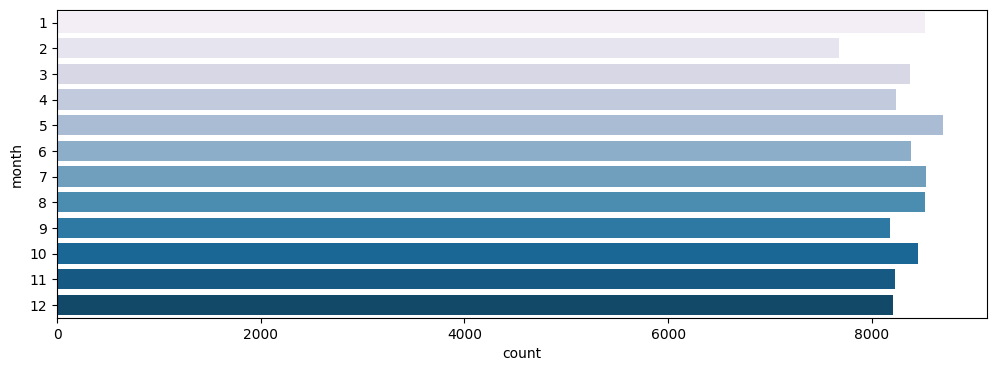

In [5]:
# Months visitors
plt.figure(1 , figsize = (12 , 4))
sns.countplot(y = 'month' , data = df, palette="PuBu")
plt.show()

**Comment:** There are no relevant differences in the number of monthly sales in the network.

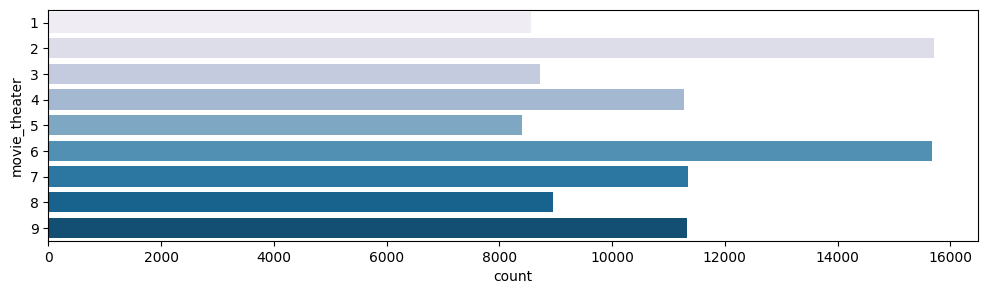

In [6]:
# Visitors by movie theater
plt.figure(1 , figsize = (12 , 3))
sns.countplot(y = 'movie_theater' , data = df, palette="PuBu")
plt.show()

In [7]:
# Visitors by movie theater
df.movie_theater.value_counts()

2    15711
6    15680
7    11351
9    11332
4    11282
8     8957
3     8718
1     8565
5     8404
Name: movie_theater, dtype: int64

**Comment:** The graph and table show that visitor per theater can be divided into 3 groups: high frequency (theaters 2 and 6), medium frequency (theaters 7, 9 and 4) and low frequency (theaters 8, 3, 1 and 5). Media room data will not be part of the model, because the company wants to run product campaigns that are common to all cinema halls.

In [8]:
# Statistics
df[['popcorn', 'soft_drink', 'sweets', 'water']].describe()

,popcorn,soft_drink,sweets,water
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.569210,1.857840,1.239590,0.711370
std,1.332084,1.588589,1.627886,1.086524
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,0.000000
75%,4.000000,3.000000,3.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000


**Comment:** The quantities of products sold range from 0 (no sales) to 5 products per person/id/index, indicating that either the person visited the cinema on up to 5 occasions during the year, or that the person purchased the same product more than once on each visit (perhaps for a companion). 

In [9]:
# Product sales by movie theater 
avg_sales = df.groupby('movie_theater')[['popcorn', 'soft_drink', 'sweets', 'water']].sum()
avg_sales = avg_sales.sort_values(by='popcorn', ascending=False)
avg_sales

,popcorn,soft_drink,sweets,water
movie_theater,,,,
9,37662,33452,29904,4210
7,37557,33210,29903,4347
4,37490,33232,30010,4258
6,30994,27744,7939,3250
2,30664,27450,7695,3214
8,21674,8560,5351,13114
3,20607,7724,4431,12883
1,20330,7370,4312,12960
5,19943,7042,4414,12901


**Comment:** Interestingly, movier goers who frequented rooms with medium frequency (9, 7 and 4) were those who made the most product purchases. Popcorn is the chain's flagship product, with significant sales at all locations. Depending on the room, sales of soft drinks increase, while mineral water decreases and vice versa. In the graphs below, we can confirm the correlations - positive and negative - between the products.

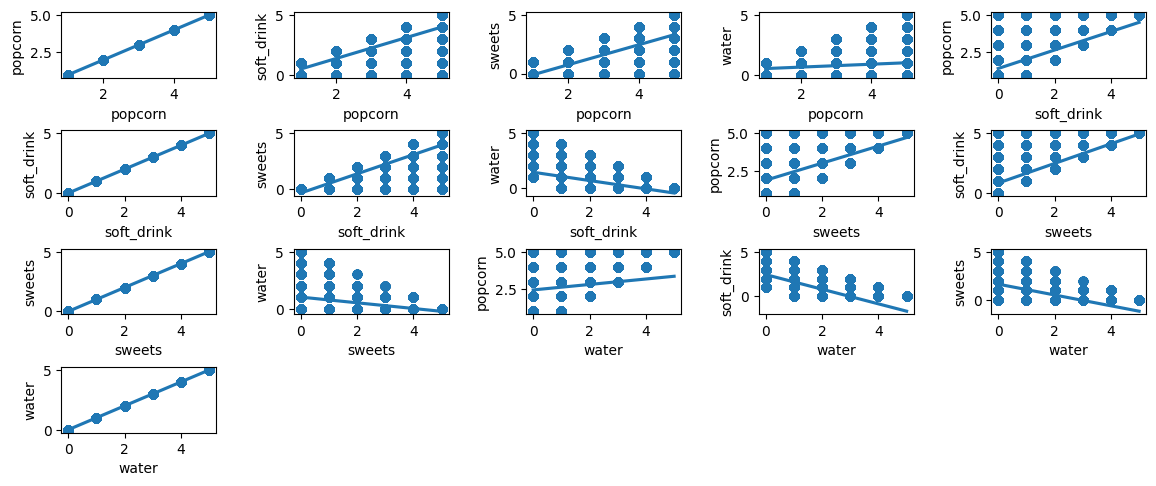

In [10]:
# Plotting correlations
plt.figure(1 , figsize = (14 , 7))

n = 0 

for x in ['popcorn' , 'soft_drink', 'sweets', 'water']:
    for y in ['popcorn' , 'soft_drink', 'sweets', 'water']:
        n += 1
        plt.subplot(5 , 5 , n)
        plt.subplots_adjust(hspace = 0.8 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y)
plt.show()

- Soft drinks and sweets sales rise as popcorn sales increase.
- Soft drinks and sweets sales decrease as sales of mineral water increase.

# <font color='orangered'>4- Data Preparation</font>

## <font color='darkblue'>Using Silhouette Score to define the ideal number of clusters</font>

In [11]:
# Sets up the silhouette score
def s2(estimator,X):
    return silhouette_score(X, estimator.predict(X))

# List of values for the parameter 'n_clusters'
param = range(2,25)

## <font color='darkblue'>Two products: Popcorn & Soft Drink</font>

Sample with 2 products: (10000, 2)
Ideal number of clusters: 20


Text(0, 0.5, 'Silhouette Score')

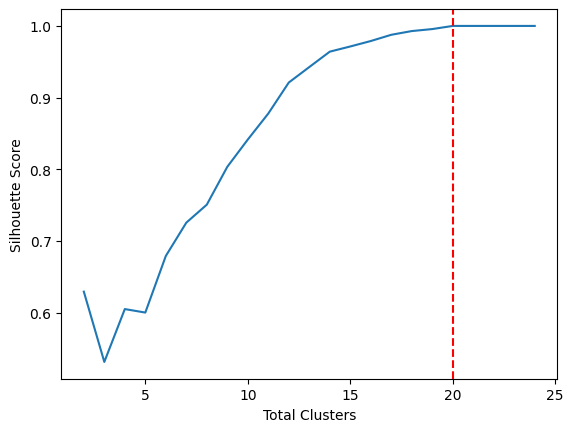

In [12]:
# Removes the non-useful columns from df
df_2p = df[['popcorn', 'soft_drink']]
sample_2p, samplea = train_test_split(df_2p, train_size = .10)
print(f"Sample with 2 products: {sample_2p.shape}")

# Calculating the silhouette score
km_2p = KMeans(init='k-means++', n_init=10)
grid_2p = GridSearchCV(km_2p, {'n_clusters': param}, scoring=s2, cv=2).fit(sample_2p)
best_2p = grid_2p.best_estimator_
print(f"Ideal number of clusters: {best_2p.n_clusters}")

# Plotting the results
plt.plot(param, grid_2p.cv_results_['mean_test_score'])
plt.axvline(x=best_2p.n_clusters, color='red', ls='--')
plt.xlabel('Total Clusters')
plt.ylabel('Silhouette Score')

- 20 is the ideal number of clusters with a silhouette score equal to 1.0
- 02 clusters will receive a silhouette score slightly above 0.60

## <font color='darkblue'>Three Products: Popcorn & Soft Drink & Sweets</font>

Sample with 3 products: (10000, 3)
Ideal number of clusters: 24


Text(0, 0.5, 'Silhouette Score')

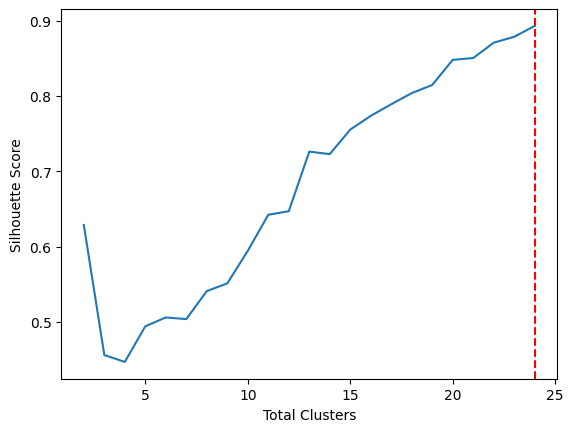

In [13]:
# Removes the non-useful columns from df
df_3p = df[['popcorn', 'soft_drink', 'sweets']]
sample_3p, sampleb = train_test_split(df_3p, train_size = .10)
print(f"Sample with 3 products: {sample_3p.shape}")

# Calculating the silhouette score
km_3p = KMeans(init='k-means++', n_init=10)
grid_3p = GridSearchCV(km_3p, {'n_clusters': param}, scoring=s2, cv=2).fit(sample_3p)
best_3p = grid_3p.best_estimator_
print(f"Ideal number of clusters: {best_3p.n_clusters}")

# Plotting the results
plt.plot(param, grid_3p.cv_results_['mean_test_score'])
plt.axvline(x=best_3p.n_clusters, color='red', ls='--')
plt.xlabel('Total Clusters')
plt.ylabel('Silhouette Score')

- 24 clusters will receive a silhouette score close to 0.90
- 02 clusters will receive a silhouette score close to 0.65

## <font color='darkblue'>Four Products: Popcorn & Soft Drink & Sweets & Water</font>

Sample with 4 products: (10000, 4)
Ideal number of clusters: 24


Text(0, 0.5, 'Silhouette Score')

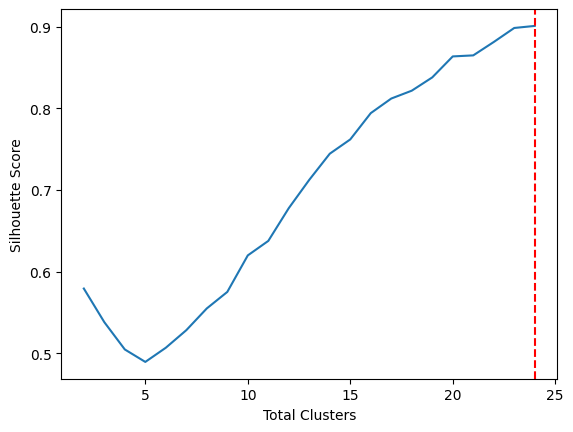

In [14]:
# Removes the non-useful columns from df
df_4p = df[['popcorn', 'soft_drink', 'sweets', 'water']]
sample_4p, samplec = train_test_split(df_4p, train_size = .10)
print(f"Sample with 4 products: {sample_4p.shape}")

# Calculating the silhouette score
km_4p = KMeans(init='k-means++', n_init=10)
grid_4p = GridSearchCV(km_4p, {'n_clusters': param}, scoring=s2, cv=2).fit(sample_4p)
best_4p = grid_4p.best_estimator_
print(f"Ideal number of clusters: {best_4p.n_clusters}")

# Plotting the results
plt.plot(param, grid_4p.cv_results_['mean_test_score'])
plt.axvline(x=best_4p.n_clusters, color='red', ls='--')
plt.xlabel('Total Clusters')
plt.ylabel('Silhouette Score')

- 24 clusters will receive a silhouette score close or equal to 0.90
- 02 clusters will receive a silhouette score lower to 0.60

## <font color='darkblue'>Number of clusters</font>

**The ideal number of clusters:** The highest scoring model for this project (silhouette score = 1.0) will require **20 groups and 2 products** (popcorn and soft drink).

**The minimum number of clusters:** If the company decides to start working with only **2 groups**, the best model will use **3 products** (score estimated at approximately 0.65).

# <font color='orangered'>5- Data Modeling</font>

## <font color='darkblue'>Model 1: Applying K-Means with 20 clusters & 2 products</font>

In [15]:
# Number of clusters
k = best_2p.n_clusters

In [16]:
%%time

# Sets up the kMeans object and fitting the data
km1 = KMeans(n_clusters = k).fit(df_2p)

# Get centroids
centroids1 = km1.cluster_centers_
labels1 = km1.labels_

# Measurement
silhouette_km1 = silhouette_score(df_2p, labels1)
print(f"Model 1 = KM with 2 products & 20 clusters - score: {silhouette_km1}")

Model 1 = KM with 2 products & 20 clusters - score: 1.0
Wall time: 2min 9s


## <font color='grey'>Meshgrid showing 20 groups</font>

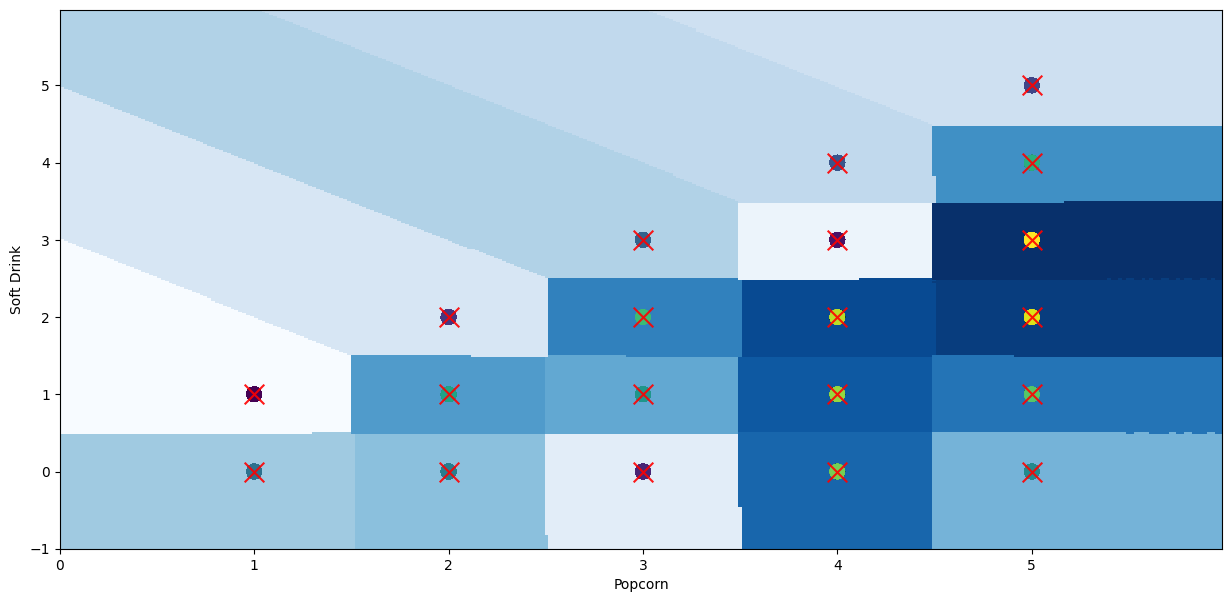

In [17]:
X1 = df_2p.iloc[: , :].values

# Meshgrid parameters
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = km1.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plotting image
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Blues, 
           aspect = 'auto', 
           origin = 'lower')

# Plotting data
plt.scatter(x = 'popcorn', y = 'soft_drink', data = df_2p, c = labels1, s = 100)
plt.scatter(x = centroids1[: , 0], y =  centroids1[: , 1], s = 200, c = 'red', alpha = 0.9, marker='x')
plt.xlabel('Popcorn')
plt.ylabel('Soft Drink')
plt.show()

## <font color='grey'>Results</font>

In [18]:
df_clusters = pd.DataFrame(labels1)
df_20_groups = df_2p.merge(df_clusters, left_index = True, right_index = True)
df_20_groups.rename(columns = {0:"Clusters_20"}, inplace = True)

# Average sales per cluster
average_sales = df_20_groups.groupby('Clusters_20')[['popcorn', 'soft_drink']].mean()
average_sales = average_sales.sort_values(by='popcorn', ascending=False)
average_sales

,popcorn,soft_drink
Clusters_20,,
19,5.0,3.0
12,5.0,4.0
18,5.0,2.0
4,5.0,5.0
14,5.0,1.0
9,5.0,0.0
17,4.0,2.0
5,4.0,4.0
16,4.0,1.0


**Comment:** 20 groups were created for the different combinations of popcorn and soft drink sales, according to the quantities purchased.

## <font color='darkblue'>Model 2: Applying K-Means with 15 clusters & 2 products</font>

In [19]:
%%time

# Sets up the kMeans object and fitting the data
km2 = KMeans(n_clusters = 15).fit(df_2p)

# Get centroids
centroids2 = km2.cluster_centers_
labels2 = km2.labels_

# Measurement
silhouette_km2 = silhouette_score(df_2p, labels2)
print(f"Model 2 = KM with 2 products & 15 clusters - score: {silhouette_km2}")

Model 2 = KM with 2 products & 15 clusters - score: 0.9765997210197631
Wall time: 2min 9s


## <font color='grey'>Meshgrid showing 15 groups</font>

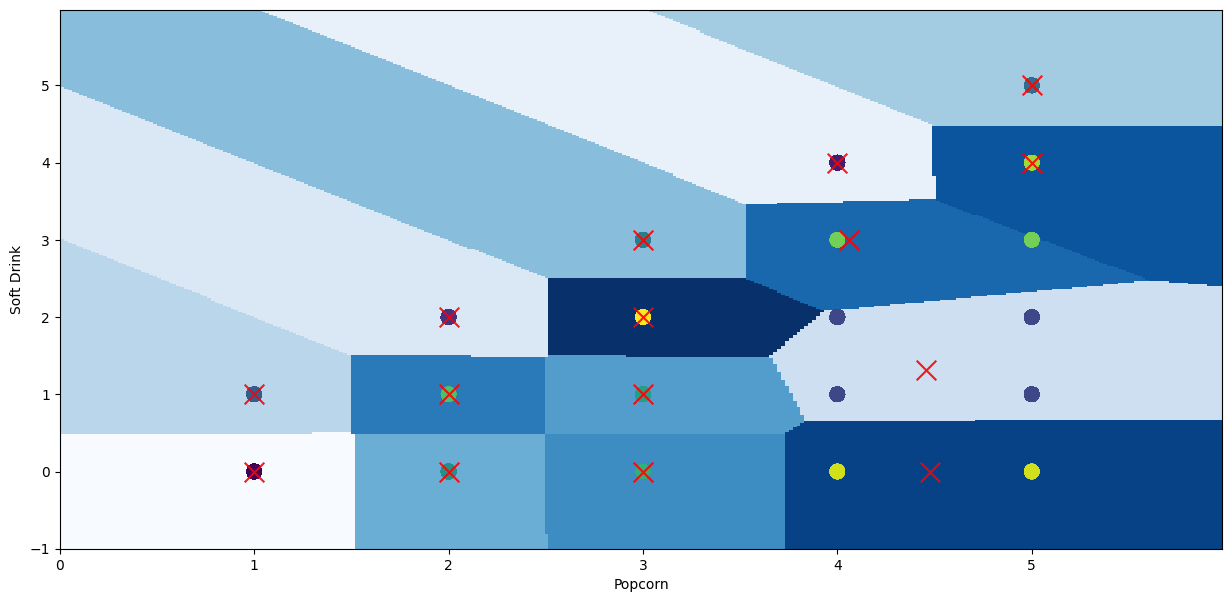

In [20]:
# Meshgrid parameters
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = km2.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (15, 7) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plotting image
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Blues, 
           aspect = 'auto', 
           origin = 'lower')

# Plotting data
plt.scatter(x = 'popcorn', y = 'soft_drink', data = df_2p, c = labels2, s = 100)
plt.scatter(x = centroids2[: , 0], y =  centroids2[: , 1], s = 200, c = 'red', alpha = 0.9, marker='x')
plt.xlabel('Popcorn')
plt.ylabel('Soft Drink')
plt.show()

## <font color='grey'>Results</font>

In [21]:
df_15_clusters = pd.DataFrame(labels2)
df_15_groups = df_2p.merge(df_15_clusters, left_index = True, right_index = True)
df_15_groups.rename(columns = {0:"Clusters_15"}, inplace = True)

# Average sales per cluster
average_sales_15 = df_15_groups.groupby('Clusters_15')[['popcorn', 'soft_drink']].mean()
average_sales_15 = average_sales_15.sort_values(by='popcorn', ascending=False)
average_sales_15

,popcorn,soft_drink
Clusters_15,,
5,5.000000,5.000000
12,5.000000,4.000000
13,4.476943,0.000000
3,4.457761,1.313094
11,4.058123,3.000000
1,4.000000,4.000000
6,3.000000,3.000000
8,3.000000,1.000000
9,3.000000,0.000000


**Comment:** 15 groups were created for the different combinations of popcorn and soft drink sales, according to the quantities purchased. There was a merger of data for the purchases of 5 & 4 popcorns with 0 to 3 soft drinks (see groups 3, 11 and 13).

## <font color='darkblue'>Model 3: Applying K-Means with 2 clusters & 3 products</font>

In [22]:
%%time

# Reducing the dimensionality of 3 variables for 2 components
pca_3p = PCA(n_components = 2).fit_transform(df_3p)

# Sets up the kMeans object and fitting the data
km3 = KMeans(n_clusters = 2).fit(pca_3p)

# Get centroids
centroids3 = km3.cluster_centers_
labels3 = km3.labels_

# Measurement
silhouette_km3 = silhouette_score(pca_3p, labels3)
print(f"Model 3 = KM with 3 products & 2 clusters - score: {silhouette_km3}")

Model 3 = KM with 3 products & 2 clusters - score: 0.6661382643466343
Wall time: 2min 20s


## <font color='grey'>Meshgrid showing 02 groups</font>

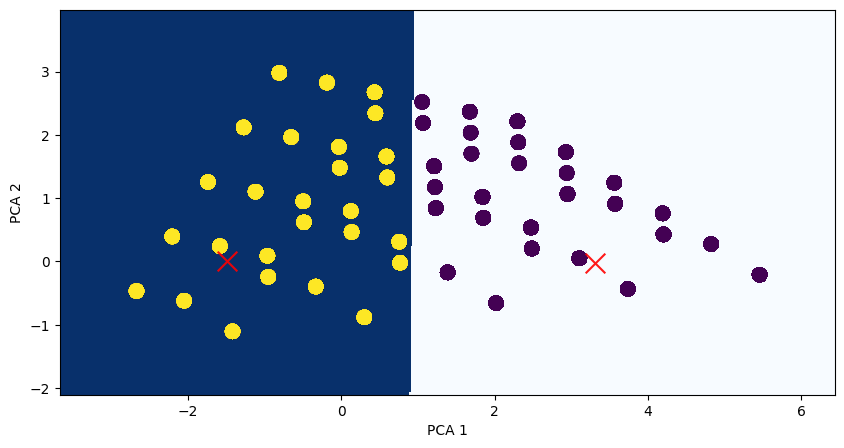

In [23]:
# Dataframe with clusters
df_pca_3p = pd.DataFrame(pca_3p)
df_pca_3p.rename(columns = {0:"PCA_1", 1:"PCA_2"}, inplace = True)

# Meshgrid parameters
h = 0.02
x_min, x_max = pca_3p[:, 0].min() - 1, pca_3p[:, 0].max() + 1
y_min, y_max = pca_3p[:, 1].min() - 1, pca_3p[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = km3.predict(np.c_[xx.ravel(), yy.ravel()]) 
plt.figure(1 , figsize = (10, 5) )
plt.clf()
Z = Z.reshape(xx.shape)

# Plotting image
plt.imshow(Z, 
           interpolation = 'nearest', 
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Blues, 
           aspect = 'auto', 
           origin = 'lower')

# Plotting data
plt.scatter(x = 'PCA_1', y = 'PCA_2', data = df_pca_3p, c = labels3, s = 100)
plt.scatter(x = centroids3[: , 0], y =  centroids3[: , 1], s = 200, c = 'red', alpha = 0.9, marker='x')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## <font color='grey'>Results</font>

In [24]:
df_clusters2 = pd.DataFrame(labels3)
df_2_groups = df_3p.merge(df_clusters2, left_index = True, right_index = True)
df_2_groups.rename(columns = {0:"Clusters_2"}, inplace = True)

# Average sales per cluster
average_sales_2 = df_2_groups.groupby('Clusters_2')[['popcorn', 'soft_drink', 'sweets']].mean()
average_sales_2 = average_sales_2.sort_values(by='popcorn', ascending=False)
average_sales_2

,popcorn,soft_drink,sweets
Clusters_2,,,
0,4.084394,3.914702,3.341515
1,1.889684,0.935383,0.296923


**Comment:** 2 groups were created for two different combinations of products sold. Group 0 includes purchases with larger quantities of each product; group 1, purchases with smaller quantities.

# <font color='orangered'>6- Measurements with Silhouette Score</font>

The models were evaluated using the **Silhouette Score**, a metric used to measure the quality of clustering. It ranges from -1 to +1, where higher scores indicate better clustering. A score of +1 means the data points are well-clustered, while a score of -1 suggests incorrect cluster assignments.

In [25]:
print(f"Model 1 = 02 products & 20 clusters - silhouette score: {silhouette_km1}")
print(f"Model 2 = 02 products & 15 clusters - silhouette score: {silhouette_km2}")
print(f"Model 3 = 03 products & 02 clusters - silhouette score: {silhouette_km3}")

Model 1 = 02 products & 20 clusters - silhouette score: 1.0
Model 2 = 02 products & 15 clusters - silhouette score: 0.9765997210197631
Model 3 = 03 products & 02 clusters - silhouette score: 0.6661382643466343


# <font color='orangered'>7- Conclusions</font>

**<font color='darkblue'>The best segmentation = 20 groups</font>**
- For this dataset, the segmentation using **2 products** (popcorn and soft drink) and **20 groups** has gotten the maximum result: a silhouette score of 1.0. 
- In total, 20 groups were created for the different combinations of popcorn and soft drink sales, according to the quantities purchased.

**<font color='darkblue'>Good segmentation = 15 groups</font>** 
- The segmentation using **2 products** (popcorn and soft drink) has also achived a great result with **15 groups**: a silhouette score of 0.9766.
- In essence, 15 groups were created for the different combinations of popcorn and soft drink sales, according to the quantities purchased, with a merger of data for the purchases of 5 & 4 popcorns with 0 to 3 soft drinks.

**<font color='darkblue'>Minimum Viable Segmentation = 2 groups</font>**
- If the company wants to start its marketing campaign with only **2 groups**, the best result was presented through the model created with **03 products** (popcorn + soft drink + sweets), whose score was 0.6661.

- In this segmentation, two groups were created for two different combinations of products sold: group 1 includes purchases with larger quantities of each product; group 2, purchases with smaller quantities.